In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import sklearn
import pickle

from utils_ridge import (
    GD, 
    RR_SVRG, 
    RR_VR,
    L_SVRG,
    SVRG,
    RR_SGD,
    SAGA_RR,
    SAGA
)
from ridge import optimal_rigde
np.random.seed(1)
random.seed(1)

In [3]:
def load_data(path, normalize = True):
    A, y = datasets.load_svmlight_file(path)
    A = A.toarray()
    if (normalize == True):
        A = sklearn.preprocessing.normalize(A, norm="l2")
    n = A.shape[0]
    d = A.shape[1]
    return A, y, n, d

def compute_constants(A, y, n, d, lambd):
    eigvals, _ = np.linalg.eigh(np.transpose(A)@A)
    eig_max = max(eigvals)
    eig_min = min(eigvals)
    L = eig_max/n+lambd
    L_i_list = []
    for i in range(n):
        L_i_list.append(np.linalg.norm(A[i,:])**2+lambd)
    mu = eig_min/n+lambd
    L_max = max(L_i_list)
    return L, mu, L_max, L_i_list

In [4]:
algo_func_pair = {
    "L-SVRG": L_SVRG,
    "RR": RR_SGD,
    "RR-SVRG": RR_SVRG,
    "SVRG": SVRG,
    "RR-SAGA": SAGA_RR,
    "SAGA": SAGA,
    "RR-VR.9": RR_VR,
    "RR-VR.5": RR_VR,
    "RR-VR.95": RR_VR,
    "RR-VR.8": RR_VR       
}

In [5]:
def main_settings(DATASET_NAME, STR_LAMBDA, NORMALIZE):
    A, y, n, d = load_data(DATASET_NAME+".txt", normalize = NORMALIZE)
    if (STR_LAMBDA == '1_n'):
        lambd = 1/n
    elif (STR_LAMBDA == '10_n'):
        lambd = 10/n
    elif (STR_LAMBDA == '1_10n'):
        lambd = 1/10/n
    L, mu, L_max, L_i_list = compute_constants(A, y, n, d, lambd)
    print("n = {}, d = {}, L = {:.5f}, L_max = {:.5f}, mu = {:.5f}, kappa = {:.5f}".format(n, d, L, L_max, mu, L_max/mu))
    x_star = optimal_rigde(A, y, lambd, n, d)
    return A, y, n, d, lambd, L, mu, L_max, L_i_list, x_star

#### Experiment #1
Comparison of RR and RR-VR.

Dataset: abalone

Algorithms: rr, rr_svrg, rr_vr0.9, rr_vr0.5

In [6]:
def myMain(algo_name, A, y, lambd, n, d, stepsize, x_star, iter_num = 100):
    if (algo_name == "RR-VR.9"):
        return algo_func_pair[algo_name](A, y, lambd, n, d, stepsize, x_star, p = 0.9, max_num_iter = iter_num)        
    if (algo_name == "RR-VR.8"):
        return algo_func_pair[algo_name](A, y, lambd, n, d, stepsize, x_star, p = 0.8, max_num_iter = iter_num)
    if (algo_name == "RR-VR.5"):
        return algo_func_pair[algo_name](A, y, lambd, n, d, stepsize, x_star, p = 0.5, max_num_iter = iter_num)    
    return algo_func_pair[algo_name](A, y, lambd, n, d, stepsize, x_star, max_num_iter = iter_num)

In [7]:
algos = ['RR', 'RR-VR.9', 'RR-VR.5', 'RR-SVRG']
DATASET_NAME = "abalone"
NORMALIZE = True
STR_LAMBDA = '1_n'

In [8]:
A, y, n, d, lambd, L, mu, L_max, L_i_list, x_star = main_settings(DATASET_NAME, STR_LAMBDA, NORMALIZE)

n = 4177, d = 8, L = 0.89819, L_max = 1.00024, mu = 0.00027, kappa = 3684.81445


In [9]:
stepsizes = [1/L, 1/2/L, 1/3/L, 1/5/L, 1/10/L]
STR_STEPSIZES = '[1/L, 1/2/L, 1/3/L, 1/5/L, 1/10/L]'

In [10]:
number_of_experiments = 1
number_of_epochs = 50
results = {}
for algo in algos:
    results[algo] = {}
    results[algo]["error"] = []
    results[algo]["epochs"] = []
    results[algo]["grad_comps"] = []
for algo in algos:
    print(algo)
    for experiment in range(number_of_experiments):
        best_error = 1e5
        best_errors = []
        best_grads = []
        best_epochs = []
        best_grad_comps = []
        for stepsize in stepsizes:
            np.random.seed(experiment)
            random.seed(experiment)
            alg_error, alg_grad, alg_epochs, alg_grad_comps = myMain(algo, A, y, lambd, \
                                                                                 n, d, stepsize, x_star, iter_num = number_of_epochs)
            print(alg_error[-1])
            if (best_error > alg_error[-1]):
                    best_error = alg_error[-1].copy()
                    best_errors = alg_error.copy()
                    best_grads = alg_grad.copy()
                    best_epochs = alg_epochs.copy()
                    best_grad_comps = alg_grad_comps.copy()
                    print(stepsize, algo)
        results[algo]['error'].append(best_errors)
        results[algo]['epochs'].append(best_epochs)    
        results[algo]['grad_comps'].append(best_grad_comps)

RR
0.006406840450014716
1.1133491276419087 RR
0.0021374924504241615
0.5566745638209544 RR
0.0014537120465304254
0.37111637588063623 RR
0.0010772934159823918
0.22266982552838177 RR
0.0005864218947570345
0.11133491276419089 RR
RR-VR.9
5.088487158386069e-25
1.1133491276419087 RR-VR.9
5.385080209209255e-25
9.669802590352965e-22
2.35570978800671e-14
1.791360196046533e-08
RR-VR.5
4.123670577104314e-24
1.1133491276419087 RR-VR.5
4.912391118769444e-25
0.5566745638209544 RR-VR.5
8.972690159765474e-22
2.3687164136827603e-14
1.7927704452608348e-08
RR-SVRG
5.337580730507183e-25
1.1133491276419087 RR-SVRG
5.011334208228712e-25
0.5566745638209544 RR-SVRG
8.323791967133575e-22
2.3106676380380342e-14
1.7962850610722427e-08


In [11]:
error_averages = {}
error_best = {}
for algo in algos:
    print(algo)
    error_averages[algo] = [sum(col) / float(len(col)) for col in zip(*results[algo]['error'])]
    error_best[algo] = min(results[algo]['error'], key=lambda x: x[-1])

RR
RR-VR.9
RR-VR.5
RR-SVRG


In [12]:
def plot_results(results, xlim = 50, ylim = 1e-15, save = False, filename = "test.pdf"):
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    for algo in algos:
        plt.semilogy(results[algo]['grad_comps'][0], error_best[algo], label = algo, marker='*')
    plt.xlim(0, xlim)
    plt.title(r"$n={}, \kappa={:.0f} $".format(n, L_max//mu), fontsize=BIGGER_SIZE)
    plt.xlabel("#gradients/n", fontsize = BIGGER_SIZE)
    plt.ylabel(r"$||x_k-x_*||^2$", fontsize = BIGGER_SIZE)
    plt.ylim(ylim, 1)
    plt.legend(fontsize = BIGGER_SIZE)
    plt.grid()
    if save:
        plt.savefig("plots/"+filename, dpi=500, bbox_inches='tight')
    plt.show()
    

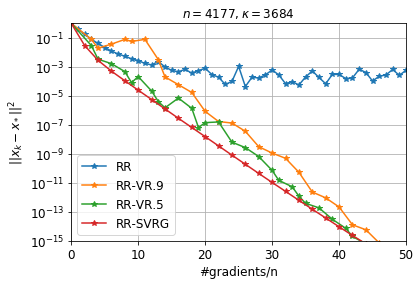

In [13]:
plot_results(results)

In [14]:
save_info = {
    "dataset": DATASET_NAME,
    "regularizer": STR_LAMBDA,
    "normalized": NORMALIZE,
    "problem": "ridge",
    "algos": algos,
    "algo_function_pair": algo_func_pair,
    "results": results,
    "number_of_experiments": number_of_experiments,
    "stepsizes": STR_STEPSIZES
}
name = 'ridge_rr_rrvr_'+DATASET_NAME
if (NORMALIZE):
    name += "_normalized_"
else:
    name += "_not_normalized_"
name += 'lambd_' + STR_LAMBDA
print(name)

ridge_rr_rrvr_abalone_normalized_lambd_1_n


In [15]:
# plot_results(results, filename=name+'.pdf', save=True)

In [16]:
# with open('plots/'+name+'.pickle', 'wb') as handle:
#     pickle.dump(save_info, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### 2nd plot

In [17]:
algos = ['RR', 'RR-VR.9', 'RR-VR.5', 'RR-SVRG']
DATASET_NAME = "abalone"
NORMALIZE = True
STR_LAMBDA = '10_n'

stepsizes = [1/L, 1/2/L, 1/3/L, 1/5/L, 1/10/L]
STR_STEPSIZES = '[1/L, 1/2/L, 1/3/L, 1/5/L, 1/10/L]'

In [18]:
A, y, n, d, lambd, L, mu, L_max, L_i_list, x_star = main_settings(DATASET_NAME, STR_LAMBDA, NORMALIZE)

n = 4177, d = 8, L = 0.90035, L_max = 1.00239, mu = 0.00243, kappa = 413.17002


In [19]:
number_of_experiments = 1
number_of_epochs = 50
results = {}
for algo in algos:
    results[algo] = {}
    results[algo]["error"] = []
    results[algo]["epochs"] = []
    results[algo]["grad_comps"] = []
for algo in algos:
    print(algo)
    for experiment in range(number_of_experiments):
        best_error = 1e5
        best_errors = []
        best_grads = []
        best_epochs = []
        best_grad_comps = []
        for stepsize in stepsizes:
            np.random.seed(experiment)
            random.seed(experiment)
            alg_error, alg_grad, alg_epochs, alg_grad_comps = myMain(algo, A, y, lambd, \
                                                                                 n, d, stepsize, x_star, iter_num = number_of_epochs)
            print(alg_error[-1])
            if (best_error > alg_error[-1]):
                    best_error = alg_error[-1].copy()
                    best_errors = alg_error.copy()
                    best_grads = alg_grad.copy()
                    best_epochs = alg_epochs.copy()
                    best_grad_comps = alg_grad_comps.copy()
                    print(stepsize, algo)
        results[algo]['error'].append(best_errors)
        results[algo]['epochs'].append(best_epochs)    
        results[algo]['grad_comps'].append(best_grad_comps)

RR
0.04851117270548658
1.1133491276419087 RR
0.02106978900476101
0.5566745638209544 RR
0.01385779721204551
0.37111637588063623 RR
0.00860149208292465
0.22266982552838177 RR
0.0036754157496385
0.11133491276419089 RR
RR-VR.9
6.496310876405272e-28
1.1133491276419087 RR-VR.9
5.191791820740909e-28
0.5566745638209544 RR-VR.9
2.3429495414797455e-28
0.37111637588063623 RR-VR.9
6.792861491699462e-28
9.830531993265489e-27
RR-VR.5
2.6195894956767556e-24
1.1133491276419087 RR-VR.5
1.2635554363042632e-27
0.5566745638209544 RR-VR.5
4.662416472628942e-28
0.37111637588063623 RR-VR.5
2.8415766163347827e-28
0.22266982552838177 RR-VR.5
1.0838723095706897e-27
RR-SVRG
4.129616876263839e-28
1.1133491276419087 RR-SVRG
3.465542269340544e-28
0.5566745638209544 RR-SVRG
3.4509985515480087e-28
0.37111637588063623 RR-SVRG
6.774272917667636e-28
1.0340972838692127e-26


In [20]:
error_averages = {}
error_best = {}
for algo in algos:
    print(algo)
    error_averages[algo] = [sum(col) / float(len(col)) for col in zip(*results[algo]['error'])]
    error_best[algo] = min(results[algo]['error'], key=lambda x: x[-1])

RR
RR-VR.9
RR-VR.5
RR-SVRG


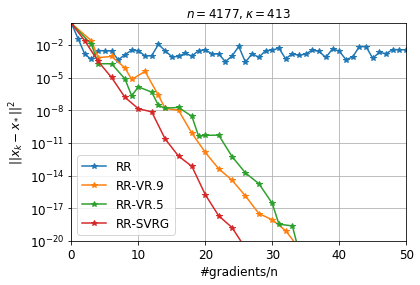

In [21]:
plot_results(results, xlim=50, ylim=1e-20)

In [22]:
save_info = {
    "dataset": DATASET_NAME,
    "regularizer": STR_LAMBDA,
    "normalized": NORMALIZE,
    "problem": "ridge",
    "algos": algos,
    "algo_function_pair": algo_func_pair,
    "results": results,
    "number_of_experiments": number_of_experiments,
    "stepsizes": STR_STEPSIZES
}
name = 'ridge_rr_rrvr_'+DATASET_NAME
if (NORMALIZE):
    name += "_normalized_"
else:
    name += "_not_normalized_"
name += 'lambd_' + STR_LAMBDA
print(name)

ridge_rr_rrvr_abalone_normalized_lambd_10_n


In [23]:
# with open('plots/'+name+'.pickle', 'wb') as handle:
#     pickle.dump(save_info, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [24]:
# plot_results(results, xlim=50, ylim=1e-20, filename=name+'.pdf', save=True)  

#### 3rd plot

In [25]:
algos = ['RR', 'RR-VR.9', 'RR-VR.5', 'RR-SVRG']
DATASET_NAME = "abalone"
NORMALIZE = True
STR_LAMBDA = '1_10n'

stepsizes = [1/L, 1/2/L, 1/3/L, 1/5/L, 1/10/L]
STR_STEPSIZES = '[1/L, 1/2/L, 1/3/L, 1/5/L, 1/10/L]'

In [26]:
A, y, n, d, lambd, L, mu, L_max, L_i_list, x_star = main_settings(DATASET_NAME, STR_LAMBDA, NORMALIZE)

n = 4177, d = 8, L = 0.89798, L_max = 1.00002, mu = 0.00006, kappa = 17862.86167


In [27]:
number_of_experiments = 1
number_of_epochs = 50
results = {}
for algo in algos:
    results[algo] = {}
    results[algo]["error"] = []
    results[algo]["epochs"] = []
    results[algo]["grad_comps"] = []
for algo in algos:
    print(algo)
    for experiment in range(number_of_experiments):
        best_error = 1e5
        best_errors = []
        best_grads = []
        best_epochs = []
        best_grad_comps = []
        for stepsize in stepsizes:
            np.random.seed(experiment)
            random.seed(experiment)
            alg_error, alg_grad, alg_epochs, alg_grad_comps = myMain(algo, A, y, lambd, \
                                                                                 n, d, stepsize, x_star, iter_num = number_of_epochs)
            print(alg_error[-1])
            if (best_error > alg_error[-1]):
                    best_error = alg_error[-1].copy()
                    best_errors = alg_error.copy()
                    best_grads = alg_grad.copy()
                    best_epochs = alg_epochs.copy()
                    best_grad_comps = alg_grad_comps.copy()
                    print(stepsize, algo)
        results[algo]['error'].append(best_errors)
        results[algo]['epochs'].append(best_epochs)    
        results[algo]['grad_comps'].append(best_grad_comps)

RR
0.0051420885857017765
1.1106847228524768 RR
0.0011834847112098957
0.5553423614262384 RR
0.000742438413673422
0.37022824095082557 RR
0.0006662810180415966
0.22213694457049538 RR
0.0030790423575403
RR-VR.9
1.8757391065410013e-13
1.1106847228524768 RR-VR.9
4.907734409216495e-08
3.940020297231938e-06
0.00013631411489404372
0.0028709799659266903
RR-VR.5
1.59552463036849e-13
1.1106847228524768 RR-VR.5
4.8855762418628274e-08
3.942114249494126e-06
0.00013640598142095853
0.0028714780484752106
RR-SVRG
2.559803269661135e-14
1.1106847228524768 RR-SVRG
4.538365809642598e-08
3.863701352287504e-06
0.0001359462646615766
0.0028732209436850165


In [28]:
error_averages = {}
error_best = {}
for algo in algos:
    print(algo)
    error_averages[algo] = [sum(col) / float(len(col)) for col in zip(*results[algo]['error'])]
    error_best[algo] = min(results[algo]['error'], key=lambda x: x[-1])

RR
RR-VR.9
RR-VR.5
RR-SVRG


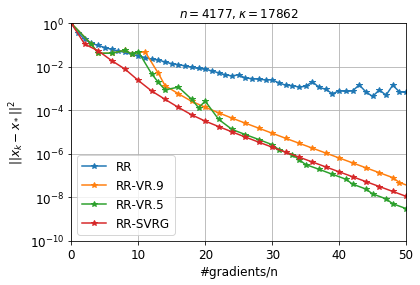

In [29]:
plot_results(results, xlim=50, ylim=1e-10)

In [30]:
save_info = {
    "dataset": DATASET_NAME,
    "regularizer": STR_LAMBDA,
    "normalized": NORMALIZE,
    "problem": "ridge",
    "algos": algos,
    "algo_function_pair": algo_func_pair,
    "results": results,
    "number_of_experiments": number_of_experiments,
    "stepsizes": STR_STEPSIZES
}
name = 'ridge_rr_rrvr_'+DATASET_NAME
if (NORMALIZE):
    name += "_normalized_"
else:
    name += "_not_normalized_"
name += 'lambd_' + STR_LAMBDA
print(name)

ridge_rr_rrvr_abalone_normalized_lambd_1_10n


In [31]:
# with open('plots/'+name+'.pickle', 'wb') as handle:
#     pickle.dump(save_info, handle, protocol=pickle.HIGHEST_PROTOCOL)
# plot_results(results, xlim=50, ylim=1e-10, filename=name+'.pdf', save=True)  